In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('notebook')

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix,classification_report, roc_curve, log_loss, brier_score_loss, roc_auc_score
from timeit import default_timer as timer

In [2]:
#Cross Validation Function

def CrossVal(model):

    start_cross_val = timer()

    scores = cross_val_score(model, X_train, y_train)

    print('Mean Accuracy:',round(scores.mean()*100,2),'%')
    print('Accuracy Standard Deviation',round(scores.std()*100,2),'%')

    end_cross_val = timer()
    print('Cross Validation Time:', round(end_cross_val - start_cross_val,1), 'seconds')

In [3]:
#Full Training Set Validation Function

def TrainVal(model, df_categorical, df_numerical, df_y):
    
    start_preprocessing = timer()

    #Create dummy columns for categorical features
    model_df = pd.get_dummies(df_categorical,
                              drop_first = True)

    #Add numerical features to model dataframe
    model_df = pd.concat([model_df, df_numerical], axis = 1)

    #Reshape response variable
    y = np.ravel(df_y)
    
    #Create scaled training and validation datasets
    X = StandardScaler().fit_transform(model_df)

    X_train, X_validation, y_train, y_validation = train_test_split(X, y, stratify = y, random_state = 33)

    end_preprocessing = timer()
    print('Preprocessing Time:', round(end_preprocessing - start_preprocessing,1), 'seconds')
    
    #Train model passed to function
    start_training = timer()

    model.fit(X_train, y_train)

    end_training = timer()
    print('Training Time:', round(end_training - start_training,1), 'seconds')

    #Use trained model to predict test results
    start_prediction = timer()

    y_pred = model.predict(X_validation)
    y_pred_prob = model.predict_proba(X_validation)[:,1]

    end_prediction = timer()
    print('Prediction Time:', round(end_prediction - start_prediction,1), 'seconds')

    #Output test reports
    start_reports = timer()

    print('Confusion Matrix:\n', confusion_matrix(y_validation, y_pred))
    print('Classification Report:\n', classification_report(y_validation, y_pred))
    print('Accuracy:', round(model.score(X_validation, y_validation) *100,2), "%")
    print('Log Loss:', log_loss(y_validation, y_pred_prob))
    print('Brier Score Loss:', brier_score_loss(y_validation, y_pred_prob))

    fpr, tpr, thresholds = roc_curve(y_validation, y_pred_prob)

    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    print('ROC AUC Score:', roc_auc_score(y_validation, y_pred_prob))
    
    forest_feature_importance = pd.DataFrame(zip(model_df.columns,model.feature_importances_))
    forest_feature_importance.sort_values(1, inplace = True)
    forest_feature_importance.reset_index(inplace = True, drop = True)

    plt.bar(forest_feature_importance[0][-20:],forest_feature_importance[1][-20:])
    plt.xticks(rotation = 'vertical')
    plt.title('20 Largest Importances')
    plt.show()

    plt.bar(forest_feature_importance[0][0:20],forest_feature_importance[1][0:20])
    plt.xticks(rotation = 'vertical')
    plt.title('20 Smallest Importances')
    plt.show()
    
    proba_df = pd.DataFrame(y_validation, columns = ['Solved'])
    proba_df['Predicted Probability'] = model.predict_proba(X_validation)[:,1]
    
    #The below bins by Predicted Probability
    bins = np.arange(0,1.05,0.05)
    labels = ['0.05','0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45','0.5',
              '0.55','0.6','0.65','0.7','0.75','0.8','0.85','0.9','0.95','1']
    proba_df['Bin'] = pd.cut(proba_df['Predicted Probability'], bins = bins, labels = labels)
    proba_df.reset_index(drop = True, inplace = True)
    chart_df = pd.DataFrame(proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean())
    chart_df['Count'] = proba_df.groupby('Bin')['Solved'].count()
    chart_df.reset_index(inplace = True)
    chart_df.columns = ['Bin', 'Actual', 'Predicted', 'Count']

    print(chart_df)
    
    plt.bar(chart_df.Bin, chart_df.Count)
    plt.xticks(rotation = 45)
    plt.title('Frequency of Test Cases by Predicted Clearance Probability')
    plt.xlabel('Case Clearance Probability')
    plt.ylabel('Number of Cases')
    plt.show()
    
    plt.scatter(chart_df.Bin, chart_df.Actual, label = 'Actual', alpha = 1)
    plt.scatter(chart_df.Bin, chart_df.Predicted, color = 'r', marker = 'D', label = 'Predicted', alpha = 0.75)
    plt.legend()
    plt.title('Actual and Predicted Clearance Rate by 5% Bin')
    plt.xticks(rotation = 45)
    plt.xlabel('Bin')
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.ylabel('Clearance Rate')
    plt.show()

    plt.scatter(chart_df.Predicted, chart_df.Actual)
    plt.plot([0,1],[0,1], linestyle = '--', color = 'g')
    plt.title('Actual vs. Predicted Clearance Rate by 5% bin')
    plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],rotation = 45)
    plt.xlabel('Predicted')
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.ylabel('Actual')
    plt.show()

    plt.bar(chart_df.Bin, chart_df.Actual - chart_df.Predicted,)
    plt.title('Actual - Predicted Clearance Rate by 5% Bin')
    plt.xticks(rotation = 45)
    plt.xlabel('Bin (Range = Value - 5% to Value)')
    plt.yticks([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05])
    plt.ylabel('Delta Clearance Rate')
    plt.show()
    
    binned_sum_of_squares = sum(((chart_df.Actual - chart_df.Predicted).fillna(0)*100) ** 2)
    print('Sum of Squared Binned Residuals:', binned_sum_of_squares)

    end_reports = timer()
    print('Reporting Time:', round(end_reports - start_reports,1), 'seconds')
    
    return proba_df

In [4]:
#murders_full = pd.read_csv('C:\\Users\\Classy\\Desktop\\murders_short.csv')
murders_no_unknowns = pd.read_csv('C:\\Users\\Classy\\Desktop\\murders_no_unknowns.csv')
#murders_unknown_ethnic = pd.read_csv('C:\\Users\\Classy\\Desktop\\murders_no_unknowns_except_VicEthnic.csv')

In [5]:
murders_no_unknowns.Solved.value_counts()

1    220148
0     88813
Name: Solved, dtype: int64

In [6]:
# Balance

solved_count, unsolved_count = murders_no_unknowns.Solved.value_counts()
solved = murders_no_unknowns[murders_no_unknowns.Solved == 1]
unsolved = murders_no_unknowns[murders_no_unknowns.Solved == 0]
solved_sample = solved.sample(unsolved_count, random_state = 33)

murders_no_unknowns = pd.concat([unsolved, solved_sample], axis = 0)

murders_no_unknowns.Solved.value_counts()

1    88813
0    88813
Name: Solved, dtype: int64

Models using no_unknowns (smallest and cleanest) dataset (with MSA excluded for now):

Preprocessing Time: 0.7 seconds
Training Time: 163.4 seconds
Prediction Time: 13.8 seconds
Confusion Matrix:
 [[15269  6935]
 [ 8479 13724]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.69      0.66     22204
           1       0.66      0.62      0.64     22203

    accuracy                           0.65     44407
   macro avg       0.65      0.65      0.65     44407
weighted avg       0.65      0.65      0.65     44407

Accuracy: 65.29 %
Log Loss: 0.6202760503974666
Brier Score Loss: 0.21579648186666373


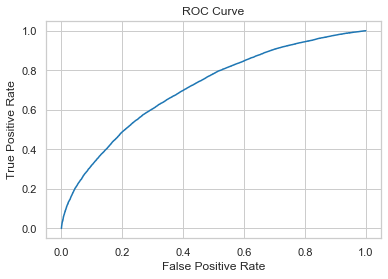

ROC AUC Score: 0.7123998924760785


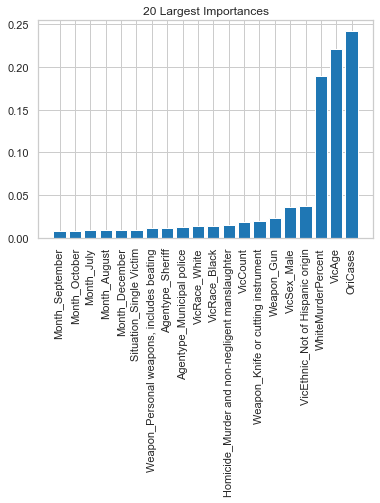

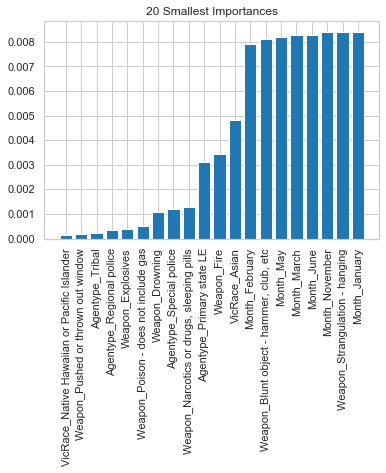

C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:84: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


     Bin    Actual  Predicted  Count
0   0.05  0.000000   0.046257      4
1    0.1  0.105882   0.078701     85
2   0.15  0.171642   0.129489    536
3    0.2  0.166963   0.176172   1126
4   0.25  0.221429   0.227586   1400
5    0.3  0.251575   0.276631   2222
6   0.35  0.287146   0.327127   4092
7    0.4  0.377645   0.374638   5341
8   0.45  0.448726   0.424310   5061
9    0.5  0.478743   0.474480   3881
10  0.55  0.518652   0.524851   3619
11   0.6  0.598994   0.575403   3975
12  0.65  0.630205   0.624105   3602
13   0.7  0.670140   0.673729   2783
14  0.75  0.730602   0.724682   2294
15   0.8  0.784431   0.774029   1837
16  0.85  0.838787   0.823425   1253
17   0.9  0.881707   0.872356    820
18  0.95  0.913462   0.920595    416
19     1  1.000000   0.960494     60


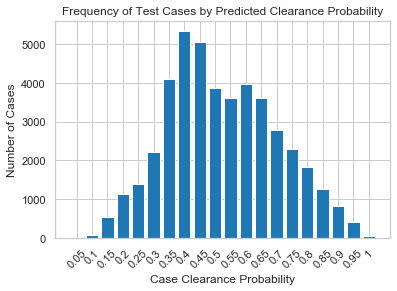

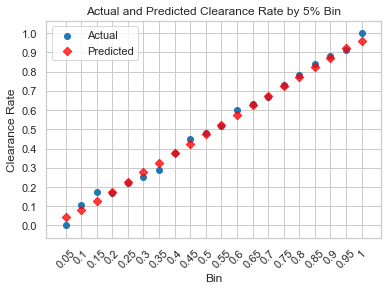

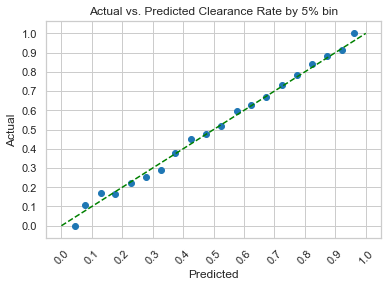

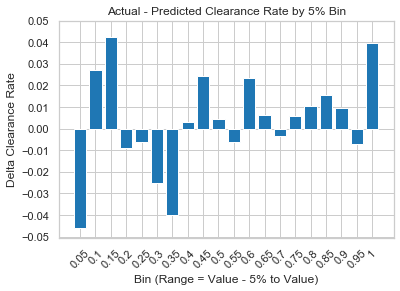

Sum of Squared Binned Residuals: 103.50992209182427
Reporting Time: 21.8 seconds


In [7]:
#Full Training Set Random Forest

forest_1 = RandomForestClassifier(n_estimators = 1000,
                                  max_depth = 20,
                                  random_state = 33,
                                  n_jobs = 3)

df_categorical = pd.get_dummies(murders_no_unknowns[[
                                                'Agentype',
                                                'Month',
                                                'Homicide',
                                                'Situation',
                                                'VicSex',
                                                'VicRace',
                                                'VicEthnic',
                                                'Weapon'
                                                    ]],
                                                drop_first = True)

df_numerical = murders_no_unknowns[[
                                    'VicAge',
                                    'VicCount',
                                    'OriCases',
                                    'WhiteMurderPercent'
                                    ]]
                                                    
y = pd.DataFrame(murders_no_unknowns.Solved)

proba_df = TrainVal(forest_1, df_categorical, df_numerical, y)

I THINK that the frequency histogram would ideally be more evenly distributed.

In [46]:
proba_df.head()

,Solved,Predicted Probability,Bin
0,0.0,0.259366,0.3
1,1.0,0.509686,0.55
2,0.0,0.475481,0.5
3,0.0,0.553375,0.6
4,1.0,0.751037,0.8


In [37]:
results_df = pd.concat([proba_df,
                        df_categorical,
                        df_numerical],
                       axis = 1)
print(results_df.columns)
bin_breakdown = pd.DataFrame()
bin_breakdown['Black'] = results_df.groupby('Bin')['VicRace_Black'].sum()
bin_breakdown['White'] = results_df.groupby('Bin')['VicRace_White'].sum()
bin_breakdown['Pacific Islander'] = results_df.groupby('Bin')['VicRace_Native Hawaiian or Pacific Islander'].sum()
bin_breakdown['Asian'] = results_df.groupby('Bin')['VicRace_Asian'].sum()
bin_breakdown['Total'] = results_df.groupby('Bin')['VicRace_Asian'].count()
bin_breakdown['Native'] = (bin_breakdown['Total'] -
    bin_breakdown['Black'] -
    bin_breakdown['White'] -
    bin_breakdown['Pacific Islander'] -
    bin_breakdown['Asian'])

bin_breakdown['Black Percent'] = bin_breakdown['Black'] / bin_breakdown['Total']
bin_breakdown['White Percent'] = bin_breakdown['White'] / bin_breakdown['Total']
bin_breakdown['Pacific Islander Percent'] = bin_breakdown['Pacific Islander'] / bin_breakdown['Total']
bin_breakdown['Asian Percent'] = bin_breakdown['Asian'] / bin_breakdown['Total']
bin_breakdown['Native Percent'] = bin_breakdown['Native'] / bin_breakdown['Total']

bin_breakdown

Index(['Solved', 'Predicted Probability', 'Bin', 'Agentype_Municipal police',
       'Agentype_Primary state LE', 'Agentype_Regional police',
       'Agentype_Sheriff', 'Agentype_Special police', 'Agentype_Tribal',
       'Month_August', 'Month_December', 'Month_February', 'Month_January',
       'Month_July', 'Month_June', 'Month_March', 'Month_May',
       'Month_November', 'Month_October', 'Month_September',
       'Homicide_Murder and non-negligent manslaughter',
       'Situation_Single Victim', 'VicSex_Male', 'VicRace_Asian',
       'VicRace_Black', 'VicRace_Native Hawaiian or Pacific Islander',
       'VicRace_White', 'VicEthnic_Not of Hispanic origin',
       'Weapon_Blunt object - hammer, club, etc', 'Weapon_Drowning',
       'Weapon_Explosives', 'Weapon_Fire', 'Weapon_Gun',
       'Weapon_Knife or cutting instrument',
       'Weapon_Narcotics or drugs, sleeping pills',
       'Weapon_Personal weapons, includes beating',
       'Weapon_Poison - does not include gas',
       'W

,Black,White,Pacific Islander,Asian,Total,Native,Black Percent,White Percent,Pacific Islander Percent,Asian Percent,Native Percent
Bin,,,,,,,,,,,
0.05,0.0,0.0,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN
0.1,18.0,35.0,0,2,56,1.0,0.321429,0.625000,0.000000,0.035714,0.017857
0.15,168.0,271.0,0,12,456,5.0,0.368421,0.594298,0.000000,0.026316,0.010965
0.2,348.0,577.0,0,36,966,5.0,0.360248,0.597308,0.000000,0.037267,0.005176
0.25,633.0,1005.0,0,52,1700,10.0,0.372353,0.591176,0.000000,0.030588,0.005882
0.3,812.0,1387.0,0,60,2271,12.0,0.357552,0.610744,0.000000,0.026420,0.005284
0.35,1346.0,2410.0,1,136,3913,20.0,0.343982,0.615896,0.000256,0.034756,0.005111
0.4,1861.0,3131.0,0,162,5175,21.0,0.359614,0.605024,0.000000,0.031304,0.004058
0.45,1824.0,3114.0,1,140,5120,41.0,0.356250,0.608203,0.000195,0.027344,0.008008


<BarContainer object of 20 artists>

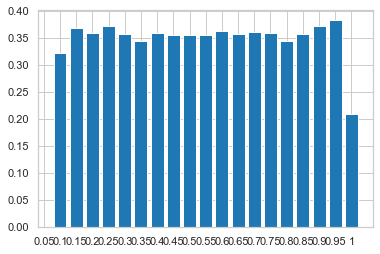

In [39]:
plt.bar(bin_breakdown.index, bin_breakdown['Black Percent'])

<BarContainer object of 20 artists>

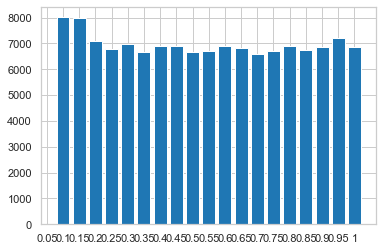

In [43]:
bin_breakdown = results_df.groupby('Bin')['OriCases'].mean()
plt.bar(bin_breakdown.index, bin_breakdown)

<BarContainer object of 20 artists>

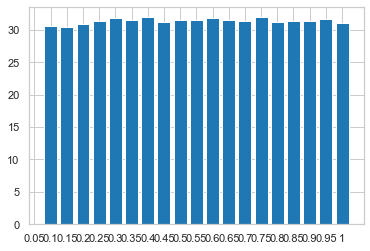

In [44]:
bin_breakdown = results_df.groupby('Bin')['VicAge'].mean()
plt.bar(bin_breakdown.index, bin_breakdown)

<BarContainer object of 20 artists>

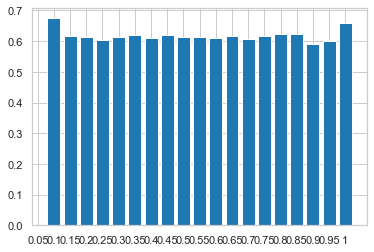

In [45]:
bin_breakdown = results_df.groupby('Bin')['WhiteMurderPercent'].mean()
plt.bar(bin_breakdown.index, bin_breakdown)

Wtf is going on here?

Try training a single decision tree and seeing what this stuff looks like

Maybe try a smaller number of bins and see what happens

Oh! Try validation on an unbalanced (or at least differently balanced) dataset and see what the results look like